# Assessment
- Anoop Nath
- nux9aq@virginia.edu
- 5/28/2023

## Part 1: Data Comprehension

**Note: For these questions, I wanted to account for team name changes. For example, I considered Seattle Supersonics and Oklahoma City Thunder as the same team/franchise. This might give different answers if team name changes are not considered.**

### (A.1) Which NBA team(s) has drafted the most players who went to Duke and were drafted in or before the 2000 draft?

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

In [2]:
draft = pd.read_csv('https://github.com/anath703/NBA_Assessment/raw/main/nbaplayersdraft.csv')

In [3]:
# Dictionary of name changes to account for franchise changing names
name_changes = {
    "CHH": "CHH/CHA",
    "WSB": "WSB/WAS",
    'WAS': 'WSB/WAS',
    "NJN": "NJN/BRK",
    "SEA": "SEA/OKC",
    "VAN": "VAN/MEM",
    "MEM": "VAN/MEM",
    "NOH": "NOH/NOP",
    "CHA": "CHH/CHA",
    "NOK": "NOH/NOP",
    "OKC": "SEA/OKC",
    "BRK": "NJN/BRK",
    "CHO": "CHH/CHA",
    "NOP": "NOH/NOP"
}
#create a new column with combined team abbreviations that accounts for name changes
draft['team_combined'] = draft['team'].map(name_changes).fillna(draft['team'])

In [4]:
# Filter for Duke players drafted in or before 2000
duke= draft[(draft['college']=='Duke') & (draft['year']<=2000)] 

In [5]:
# Count the number of players drafted by each team
duke['team_combined'].value_counts().head()

team_combined
DAL    2
MIN    2
PHO    2
LAC    1
POR    1
Name: count, dtype: int64

**The Dallas Mavericks, Minnesota Timberwolves, and Phoenix Suns have drafted the most players who went to Duke and were drafted in or before the 2000 draft, with eaching drafting two players.**

### (A.2) Which NBA team(s) has drafted the most players  who have a first name that begins with D and were drafted in an even year draft (1990, 1992, 1994, …)?

In [6]:
draft['first_letter'] = draft['player'].str[0]
d_names_and_even_years= draft[(draft['first_letter']=='D') & (draft['year']%2==0)] 

In [7]:
d_names_and_even_years['team_combined'].value_counts().head()

team_combined
SEA/OKC    8
BOS        7
MIL        7
ATL        6
MIA        5
Name: count, dtype: int64

**The Seattle Supersonics/Oklahoma City Thunder have drafted the most players who have a first name that begins with D and were drafted in an even year draft**

### (B) Describe the relationship between a team’s first round pick slot in one year with their first-round pick slot in the subsequent year.

The dataset doesn’t indicate which round a pick is made so I will have to get creative to extract this information.

In [8]:
# Calculate the maximum overall_pick for each year and divide by 2
round_threshold = draft.groupby('year')['overall_pick'].max() / 2

round_threshold[1997] = 28 #The Wizards forfeited their first round pick so I'm manually adjusting
round_threshold[2004] = 29 #The Timberwolves forfeited their first round pick so I'm manually adjusting

In [9]:
# Map the round_threshold series to the draft dataframe using the year column
draft['round_threshold'] = draft['year'].map(round_threshold)

# Create a new column 'round' based on the condition
draft['round'] = np.where(draft['overall_pick'] > draft['round_threshold'], 2, 1)

# Drop the 'round_threshold' column as it's no longer needed
draft = draft.drop(columns='round_threshold')

I now have the round for each selection and can continue with my analysis.

In [10]:
# Group by team and year and get the smallest overall pick
first_round_picks = draft[draft['round'] == 1].groupby(['team', 'year'])['overall_pick'].min().reset_index()

# Sort by team and year
first_round_picks = first_round_picks.sort_values(['team', 'year'])

# Get the subsequent year's pick using shift() function
first_round_picks['next_year_pick'] = first_round_picks.groupby('team')['overall_pick'].shift(-1)

# Drop NaN rows (i.e., the last year for each team will not have a 'next_year_pick')
first_round_picks = first_round_picks.dropna(subset=['next_year_pick'])

# Make sure 'next_year_pick' is integer
first_round_picks['next_year_pick'] = first_round_picks['next_year_pick'].astype(int)

<Figure size 1000x600 with 0 Axes>

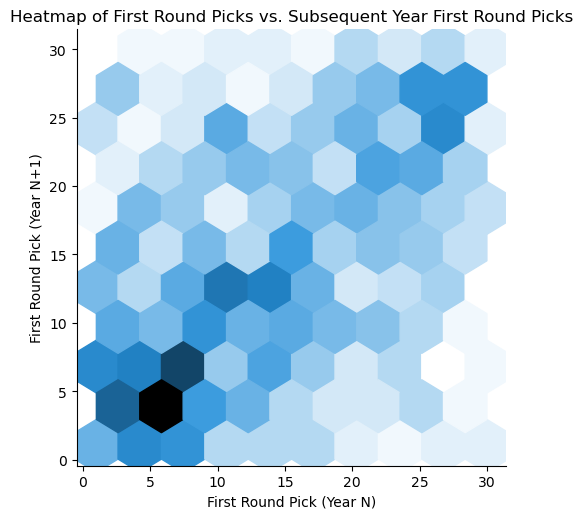

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
heatmap= sns.jointplot(data=first_round_picks, x='overall_pick', y='next_year_pick', kind='hex')
heatmap.ax_marg_x.remove()
heatmap.ax_marg_y.remove()
plt.title('Heatmap of First Round Picks vs. Subsequent Year First Round Picks')
plt.xlabel('First Round Pick (Year N)')
plt.ylabel('First Round Pick (Year N+1)')

plt.show()

We can see a linear relationship between first round pick this year and first round pick next year. This seems more pronounced for teams drafting in the top 10. It seems like struggling teams that are picking early tend to stay in that area from year-to-year.

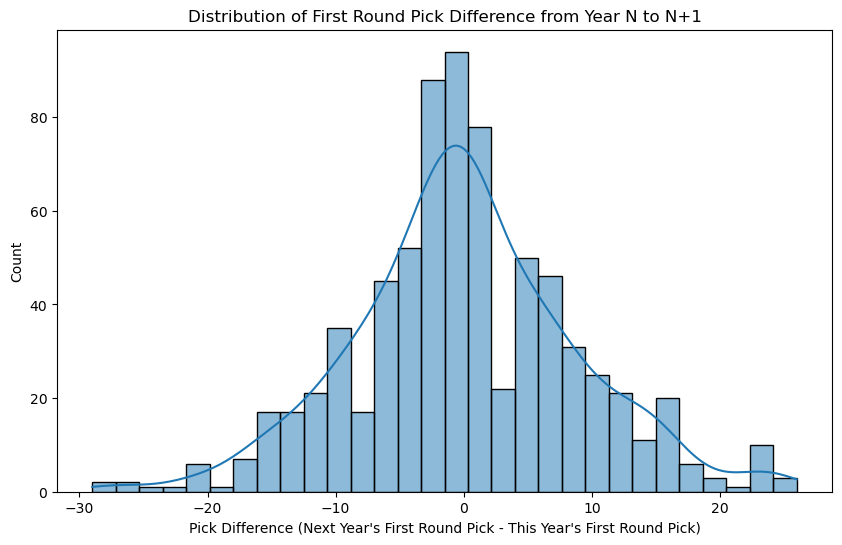

In [12]:
# Calculate the difference between next year's draft pick and this year's draft pick
first_round_picks['pick_difference'] = first_round_picks['next_year_pick'] - first_round_picks['overall_pick']

# Plot the distribution of the pick difference
plt.figure(figsize=(10, 6))
sns.histplot(data=first_round_picks, x='pick_difference', kde=True, bins=30)
plt.title('Distribution of First Round Pick Difference from Year N to N+1')
plt.xlabel("Pick Difference (Next Year's First Round Pick - This Year's First Round Pick)")
plt.show()

We can see a similar relationship here. The distribution between next year's first round pick and this year's pick is centered around 0, meaning teams tend to stay where they are from year-to-year.

## Part 2: Analytical Acumen

Analyze draft position value and team success/deficiencies compared to expectation


### **(a)** Create a method for valuing each draft slot in the NBA Draft (picks 1 through 60 in most drafts).

I want to calculate the average win shares for each pick position

In [13]:
# Calculate the average career win shares for each draft slot
average_win_shares = draft.groupby('overall_pick')['win_shares'].mean().reset_index()

# Rename the columns 
average_win_shares.columns = ['Draft Slot', 'Average Career Win Shares']
average_win_shares

,Draft Slot,Average Career Win Shares
0,1,61.748485
1,2,46.251515
2,3,52.778788
3,4,48.160606
4,5,45.384848
5,6,21.739394
6,7,30.509091
7,8,21.854545
8,9,39.530303
9,10,34.172727


This is a good start but some outliers (especially in the second round) really skew the data. I want to smooth the data to account for this and will use a reciprocal function since that seems to fit the data well. 

In [14]:
# Define the form of the function we want to fit
def reciprocal(x, a, h, k):
    return a / (x - h) + k

In [15]:
# Define bounds for each parameter for the differential evolution
bounds = [(0, 100), (-50, 50), (0, 100)] 

In [16]:
# Use differential evolution to determine the initial guesses
result = differential_evolution(lambda x: np.sum((reciprocal(average_win_shares['Draft Slot'], *x) - average_win_shares['Average Career Win Shares'])**2), bounds)

In [17]:
# Now we can use curve_fit with these initial guesses
params, params_covariance = curve_fit(reciprocal, average_win_shares['Draft Slot'], average_win_shares['Average Career Win Shares'], p0=result.x)

# Create x values for the fitted curve
x_fit = np.linspace(average_win_shares['Draft Slot'].min(), average_win_shares['Draft Slot'].max(), 500)

# Create y values for the fitted curve
y_fit = reciprocal(x_fit, *params)

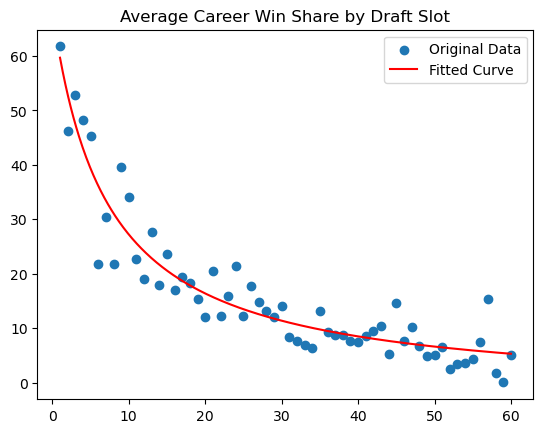

In [18]:
# Plot the original data
plt.scatter(average_win_shares['Draft Slot'], average_win_shares['Average Career Win Shares'], label='Original Data')

# Plot the fitted curve
plt.plot(x_fit, y_fit, 'r', label='Fitted Curve')

#add a title
plt.title('Average Career Win Share by Draft Slot')
# Add a legend
plt.legend()

# Show the plot
plt.show()

It's not perfect but the fitted curve seems to fit the data well. It does tend to overvalue late picks (50+) due to outliers.

Let's see what the value of each draft position is:

In [19]:
# Create an array of draft slots
draft_slots = np.arange(1, 61)

# Compute the value for each slot using the fitted function
pick_values = reciprocal(draft_slots, *params)

# Create a dataframe from the draft slots and pick values
pick_values_df = pd.DataFrame({
    'Draft Slot': draft_slots,
    'Pick Value': pick_values
})
print(pick_values_df.to_string(index=False))

 Draft Slot  Pick Value
          1   59.682366
          2   52.922088
          3   47.492897
          4   43.036894
          5   39.313934
          6   36.156880
          7   33.445815
          8   31.092469
          9   29.030423
         10   27.208743
         11   25.587715
         12   24.135919
         13   22.828168
         14   21.644038
         15   20.566790
         16   19.582578
         17   18.679850
         18   17.848887
         19   17.081460
         20   16.370550
         21   15.710134
         22   15.095019
         23   14.520697
         24   13.983240
         25   13.479210
         26   13.005583
         27   12.559687
         28   12.139157
         29   11.741887
         30   11.366001
         31   11.009817
         32   10.671825
         33   10.350666
         34   10.045113
         35    9.754057
         36    9.476488
         37    9.211491
         38    8.958231
         39    8.715945
         40    8.483934
         41    8

### (b1) Conditional on the expected value of the draft positions, which NBA teams have over or underperformed the most when drafting during this time span.

In [20]:
# Merge the pick values dataframe with the draft dataframe
merged_df = pd.merge(draft, pick_values_df, left_on='overall_pick', right_on='Draft Slot', how='left')

# Adjust 'Pick Value' to be per season assuming a 10-year career
merged_df['Adjusted Pick Value'] = merged_df['Pick Value'] / 10

# Calculate win shares per season
merged_df['win_shares_per_season'] = merged_df['win_shares'] / merged_df['years_active']

# Replace NaN values in column with 0
merged_df['win_shares_per_season'] = merged_df['win_shares_per_season'].fillna(0)

# Calculate the difference between actual win shares per season and the adjusted pick value
merged_df['Difference'] = merged_df['win_shares_per_season'] - merged_df['Adjusted Pick Value']


In [21]:
# Group by team and calculate the average difference
team_performance = merged_df.groupby('team_combined')['Difference'].mean()

# Display the team performance
print(team_performance.sort_values(ascending=False))

team_combined
SEA/OKC    0.331649
SAS        0.321558
IND        0.232179
DEN        0.218903
LAL        0.185334
HOU        0.147215
TOR        0.125225
NOH/NOP    0.081138
GSW        0.051930
UTA        0.001750
MIL       -0.010342
CLE       -0.022318
BOS       -0.038303
NJN/BRK   -0.045056
DET       -0.050412
PHO       -0.078618
MIA       -0.106500
PHI       -0.177257
CHH/CHA   -0.199513
SAC       -0.209847
CHI       -0.238508
POR       -0.255726
MIN       -0.262351
NYK       -0.305632
VAN/MEM   -0.323317
ATL       -0.343540
WSB/WAS   -0.348325
ORL       -0.358738
DAL       -0.427429
LAC       -0.647043
Name: Difference, dtype: float64


The three teams that have overperformed the most when drafting are:
- Seattle Supersonics/Oklahoma City Thunder
- San Antonio Spurs
- Indiana Pacers

The three teams that have underperformed the most when drafting are:

- Los Angeles Clippers
- Dallas Mavericks
- Orlando Magic

### ***(b2) Which College Teams have had the players outperform expectations the most after entering the NBA?***
note: To account for outliers, I only analzyed colleged that have had at least five players drafted to the NBA

In [22]:
# Group by college and filter
filtered_draft = merged_df.groupby('college').filter(lambda x: len(x) >= 5)

# Now, we compute the average performance difference for each college
college_performance = filtered_draft.groupby('college')['Difference'].mean()

#college_performance = college_performance.dropna()

# Sort in descending order to see which colleges' players outperformed expectations the most
college_performance = college_performance.sort_values(ascending=False)

college_performance.sort_values(ascending=False).head(3)

college
Wake Forest       1.861873
Texas A&M         1.510045
Louisiana Tech    1.202630
Name: Difference, dtype: float64

The three colleges that have had players outperform expectations the most are: 
- Wake Forest
- Texas A&M
- Louisiana Tech